# *Dealing with unbalanced data by Model Ensembling * 

# Abstract

---

This report focuses in the research of the best transformations to apply to the initial dataset and the search for the best models  to provide good accuracy and logloss function. The first particularity of the dataset in question is its unbalanced nature and the approach we found it worked better to deal with it was to assemble different machine learning models.

The first step done  is to generate different datasets with some transformations on them. In our case we have 4 dataset to feed the models which we evaluate to keep the one providing better metrics.  We realize that the unique transformation that gives better performance is a scaling of the data, concretely the MinMax.

The second step is to focus on techniques to deal with unbalanced datasets and see their performances on the metrics. Again, after some tries no good results obtained.

Finally, we realized that the best way to increase our model metrics was to assemble the best models obtained with a model-hyperparametrization search performed with GridSearch.

---





# 1. Introduction

It is well known that music is an important part of our society. Numerous technologies have been implemented around that sector since decades ago. Nowadays, within the online streaming online era, just with an internet connection you can listen any song at anytime in any place in the world.

This project focuses on the task of identifying music genre of songs. From some spectral information of each song we should be capable to come up with a method to classify the song inside a unique genere. This task can be useful for different applications  such as to be used in a recomendation music system.

The problem of automatic music genre classification  (AMGC)  is complicated: while some genre
distinctions are fairly straightforward (e.g. heavy metal vs classical), others are much fuzzier (e.g. rock vs blues).

Our main objective in this project is to come up with the best possible model in terms of accuracy and log loss and learning during the process the why of that selection.

Our aproach to find the best possible model can be summarized with the following bullet points. 

**1.   Data Analisys**


*   Ourlier search
*   Remove high correlated columns
*   PCA
*   Balancing the data


**2.   Machine Learning Method**


*   Grid Search with state of the art models
*   Ensembling

Since the random guess shoud give an accuracy of 10% we would consider a success if we  are able to develop a system with and accuracy around 60%. Obviously things like the balance of the classes should be taken into account and if the data is unbalanced that random guess will be higher.







# 2. Data analysis

In this part, we have performed some analysis of our data focused in obtaining the best dataset to feed our model. We have tryed different kind of improvements in our initial data;  dimensionality reduction, searching of outliers and correction of the unbalanced data.
 

In [0]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

## Load our Data

In [0]:
df_train_data = pd.read_csv("train_data.csv",header=None)
df_train_labels = pd.read_csv("train_labels.csv",header=None)
df_test_data = pd.read_csv("test_data.csv",header=None)

Rename columns

In [0]:

columnsD = []
for i in range(1,df_train_data.shape[1]+1):
    txt = ""
    if i <= 24:
        txt = "mean_band_"+str(i)        
    elif i <= 24*2:
        txt = "median_band_"+str(i-24)
    elif i <= 24*3:
        txt = "variance_band_"+str(i-24*2)
    elif i <= 24*4:
        txt = "kurtosis_band_"+str(i-24*3)
    elif i <= 24*5:
        txt = "skewness_band_"+str(i-24*4)
    elif i <= 24*6:
        txt = "min_band_"+str(i-24*5)
    elif i <= 24*7:
        txt = "max_band_"+str(i-24*6)
    elif i <= (24*7)+12:
        txt = "mean_pc_"+str(i-((24*7)))
    elif i <= (24*7)+(12*2):
        txt = "stan_deriv_pc_"+str(i-((24*7)+12))
    elif i <= (24*7)+(12*3):
        txt = "min_pc_"+str(i-((24*7)+(12*2)))
    elif i <= (24*7)+(12*4):
        txt = "max_pc_"+str(i-((24*7)+(12*3)))
    elif i <= (24*7)+(12*4)+12:
        txt = "mean_coef_"+str(i-((24*7)+(12*4)))
    elif i <= (24*7)+(12*4)+(12*2):
        txt = "stan_deriv_coef_"+str(i-((24*7)+(12*4)+12))
    elif i <= (24*7)+(12*4)+(12*3):
        txt = "min_coef_"+str(i-((24*7)+(12*4)+(12*2)))
    elif i <= (24*7)+(12*4)+(12*4):
        txt = "max_coef_"+str(i-((24*7)+(12*4)+(12*3)))
    
        
    columnsD.append(txt)
    
df_test_data.columns = columnsD
df_train_data.columns = columnsD

#In the future it can be expanded to more features
columnsL = []
for i in range(1,df_train_labels.shape[1]+1):
    columnsL.append("Column_"+str(i))
df_train_labels.columns = columnsL


df_train_labels["Column_1"] = df_train_labels["Column_1"].astype('category')

threshold_zscore = 3
threshold_corr = 0.9


Calculating some basic stats of our variables

In [116]:
#Analysis of the input data
print(df_train_data.info())
print(df_train_data.describe())
#table_miss = df_train_data.isna()

null_columns=df_train_data.columns[df_train_data.isnull().any()]
print("Columns with Null values")
print(df_train_data[df_train_data.isnull().any(axis=1)][null_columns])
df_train_data[null_columns].isnull().sum()

null_columns=df_train_data.columns[df_train_data.isna().any()]
print("Columns with NaN values")
print(df_train_data[df_train_data.isna().any(axis=1)][null_columns])
df_train_data[null_columns].isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4363 entries, 0 to 4362
Columns: 264 entries, mean_band_1 to max_coef_12
dtypes: float64(264)
memory usage: 8.8 MB
None
       mean_band_1  mean_band_2  mean_band_3  mean_band_4  mean_band_5  \
count  4363.000000  4363.000000  4363.000000  4363.000000  4363.000000   
mean   3097.683714  4390.947408  3987.672465  4004.861996  3086.664978   
std    1309.219331  1457.625815  1228.185868  1242.336635  1031.020501   
min       1.240000     3.565000    73.644000   147.370000    58.027000   
25%    2200.900000  3386.150000  3128.650000  3173.200000  2373.000000   
50%    3114.600000  4376.800000  3988.500000  3976.300000  3041.300000   
75%    3949.150000  5391.900000  4814.950000  4795.300000  3741.400000   
max    9172.400000  9062.500000  8318.100000  9342.200000  8275.700000   

       mean_band_6  mean_band_7  mean_band_8  mean_band_9  mean_band_10  \
count  4363.000000  4363.000000  4363.000000  4363.000000   4363.000000   
mean   3329.8

Series([], dtype: float64)

## Seeking Outliers

Now, we proceed to search for outliers. Two methods have been used: IQR and Z-score. After some testing and some ressearch on internet we came to the conclusion that the IQR method is more robust and performs much better than the Z-score, at least for our data.

When an outlier is found in the dataset is changed to the mean of the variable, there are other ways to deal with them but we found it the most convenient for our case, for example another way is to remove the entire row but in that case a lot of information is lost in case to have big number of outliers.

(It is included a link in the references section if the reader wants to know more about these methods)

In [117]:
'''#Seeking Outliers

df_train_data_nout = df_train_data.copy() 
thresholds = [30,3,15,30]

for t in thresholds:
  z = np.abs(stats.zscore(df_train_data_nout))
  print('Threshold: '+str(t))
  out = np.where(z > t)

  print('Amount of variables: '+str(out[1].shape[0]))

  cols_out = []
  for name in out[1]:
    colname = df_train_data_nout.columns[name]
    cols_out.append(colname)

  out_df = pd.DataFrame(
      {'Colum': cols_out,
       'Index': out[0]
      })
  
  print("Columns to fix:")
  print(out_df)
  for i in range(int(out[1].shape[0])):
    df_train_data_nout.iat[out[0][i],out[1][i]] = df_train_data_nout[df_train_data_nout.columns[out[1][i]]].mean()'''

'#Seeking Outliers\n\ndf_train_data_nout = df_train_data.copy() \nthresholds = [30,3,15,30]\n\nfor t in thresholds:\n  z = np.abs(stats.zscore(df_train_data_nout))\n  print(\'Threshold: \'+str(t))\n  out = np.where(z > t)\n\n  print(\'Amount of variables: \'+str(out[1].shape[0]))\n\n  cols_out = []\n  for name in out[1]:\n    colname = df_train_data_nout.columns[name]\n    cols_out.append(colname)\n\n  out_df = pd.DataFrame(\n      {\'Colum\': cols_out,\n       \'Index\': out[0]\n      })\n  \n  print("Columns to fix:")\n  print(out_df)\n  for i in range(int(out[1].shape[0])):\n    df_train_data_nout.iat[out[0][i],out[1][i]] = df_train_data_nout[df_train_data_nout.columns[out[1][i]]].mean()'

In [118]:
#Seeking outliers 2  IQR
df_iqr = df_train_data.copy()

thresholds = [100.0,2.5]
for t in thresholds:
  q1 = df_iqr.quantile(0.25)
  q3 = df_iqr.quantile(0.75)

  iqr = q3 - q1
  df_iqr_index = (df_iqr < (q1 - t * iqr)) |(df_iqr > (q3 + t * iqr))
  
  info = df_iqr_index.apply(pd.value_counts).fillna(0)
  print('Threshold: '+str(t))
  print('Amount of values: ')
  print(info[columnsD].sum(axis=1))
  print("For each variable: ")
  print(info)
  

  for col in columnsD:
    df_iqr.loc[df_iqr_index[col] == True, col] = df_iqr[col].mean()


df_train_data_nout = df_iqr.copy()


Threshold: 100.0
Amount of values: 
False    1145868.0
True        5964.0
dtype: float64
For each variable: 
       mean_band_1  mean_band_2  mean_band_3  mean_band_4  mean_band_5  \
False       4363.0       4363.0       4363.0       4363.0       4363.0   
True           0.0          0.0          0.0          0.0          0.0   

       mean_band_6  mean_band_7  mean_band_8  mean_band_9  mean_band_10  \
False       4363.0       4363.0       4363.0       4363.0        4363.0   
True           0.0          0.0          0.0          0.0           0.0   

          ...       max_coef_3  max_coef_4  max_coef_5  max_coef_6  \
False     ...           4363.0      4363.0      4363.0      4363.0   
True      ...              0.0         0.0         0.0         0.0   

       max_coef_7  max_coef_8  max_coef_9  max_coef_10  max_coef_11  \
False      4363.0      4363.0      4363.0       4363.0       4363.0   
True          0.0         0.0         0.0          0.0          0.0   

       max_coef_1

## Lookin for high correlated variables to reduce the dimensionality

This search is performed in 3 steps:

1. Getting the most correlated variables with the target
2. Reduce the dimensionality dropping high correlated variables (without target)
3. Check result 

In [119]:
#Step 1: Look for high correlated values with the target

print("Step 1: Looking for the most correlated variables with the target (outliers)")
df_train_labels["Column_1"] = df_train_labels["Column_1"].astype('category')
dummies = pd.get_dummies(df_train_labels[['Column_1']])

union = pd.concat([df_train_data, dummies ], axis = 1)


corr = union.corr()


print('Correlations with the dummy variables')
for i in range(1,11):
  print('Correlations of: '+str(i))
  print(corr["Column_1_"+str(i)].sort_values(ascending  = False).take(range(0,10)))



Step 1: Looking for the most correlated variables with the target (outliers)
Correlations with the dummy variables
Correlations of: 1
Column_1_1     1.000000
min_band_15    0.442100
min_band_16    0.439780
min_band_14    0.438530
min_band_17    0.434704
min_band_12    0.428323
min_band_13    0.427397
min_band_18    0.426613
min_band_2     0.425299
min_band_19    0.409050
Name: Column_1_1, dtype: float64
Correlations of: 2
Column_1_2           1.000000
stan_deriv_coef_2    0.348040
stan_deriv_coef_3    0.230584
mean_coef_11         0.226120
mean_pc_1            0.199153
max_coef_5           0.197680
variance_band_15     0.194969
variance_band_16     0.194225
stan_deriv_coef_5    0.194149
stan_deriv_coef_6    0.193347
Name: Column_1_2, dtype: float64
Correlations of: 3
Column_1_3            1.000000
stan_deriv_coef_8     0.389792
median_band_1         0.364733
stan_deriv_coef_10    0.348988
variance_band_2       0.309747
mean_coef_6           0.280035
stan_deriv_coef_11    0.263407
media

In [120]:
print("Step 1: Looking for the most correlated variables with the target (no outliers)")
dummies = pd.get_dummies(df_train_labels[['Column_1']])

union = pd.concat([df_train_data_nout, dummies ], axis = 1)


corr = union.corr()

print('Correlations with the dummy variables')
for i in range(1,11):
    print('Correlations of: '+str(i))
    print(corr["Column_1_"+str(i)].sort_values(ascending  = False).take(range(0,10)))

Step 1: Looking for the most correlated variables with the target (no outliers)
Correlations with the dummy variables
Correlations of: 1
Column_1_1     1.000000
min_band_15    0.439997
min_band_14    0.438859
min_band_16    0.438429
min_band_17    0.433596
min_band_12    0.428201
min_band_13    0.427245
min_band_18    0.426913
min_band_2     0.425299
min_band_19    0.412497
Name: Column_1_1, dtype: float64
Correlations of: 2
Column_1_2           1.000000
stan_deriv_coef_2    0.269578
mean_coef_11         0.222044
stan_deriv_coef_3    0.219555
mean_pc_1            0.199153
max_coef_5           0.192954
mean_pc_2            0.192233
max_coef_7           0.188308
stan_deriv_coef_5    0.174685
mean_coef_7          0.170805
Name: Column_1_2, dtype: float64
Correlations of: 3
Column_1_3            1.000000
stan_deriv_coef_8     0.381449
stan_deriv_coef_10    0.347488
stan_deriv_coef_11    0.298273
variance_band_2       0.294591
median_band_1         0.282203
mean_coef_6           0.281003
st

As we can see, the most correlated variables with the first category of the target have almost the same correlation. It is a bit suspicious 

In [121]:
corr.loc["min_band_14":"min_band_17", "min_band_14":"min_band_17"]

,min_band_14,min_band_15,min_band_16,min_band_17
min_band_14,1.000000,0.927279,0.909338,0.883884
min_band_15,0.927279,1.000000,0.931971,0.904261
min_band_16,0.909338,0.931971,1.000000,0.932539
min_band_17,0.883884,0.904261,0.932539,1.000000


That values are due to the high correlation among them.

Other rare value that appears in the correlation matrix is NaN, it means each one of  those columns have the same value in their cells. Therefore they should be removed as they do not give usefull information.

In [0]:
corr["Column_1_1"].sort_values(ascending  = False)

df_train_data_clean = df_train_data.drop(["mean_coef_1","mean_coef_2","mean_coef_3","mean_coef_4"], axis=1)
df_train_data_nout_clean = df_train_data_nout.drop(["mean_coef_1","mean_coef_2","mean_coef_3","mean_coef_4"], axis=1)
df_test_data_clean = df_test_data.drop(["mean_coef_1","mean_coef_2","mean_coef_3","mean_coef_4"], axis=1)



Step 2: Reduce the dimensionality dropping high correlated variables (without target)
Let's plot the correlation matrix


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
         63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
         72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
         81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
         90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
         99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
        108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
        117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
      

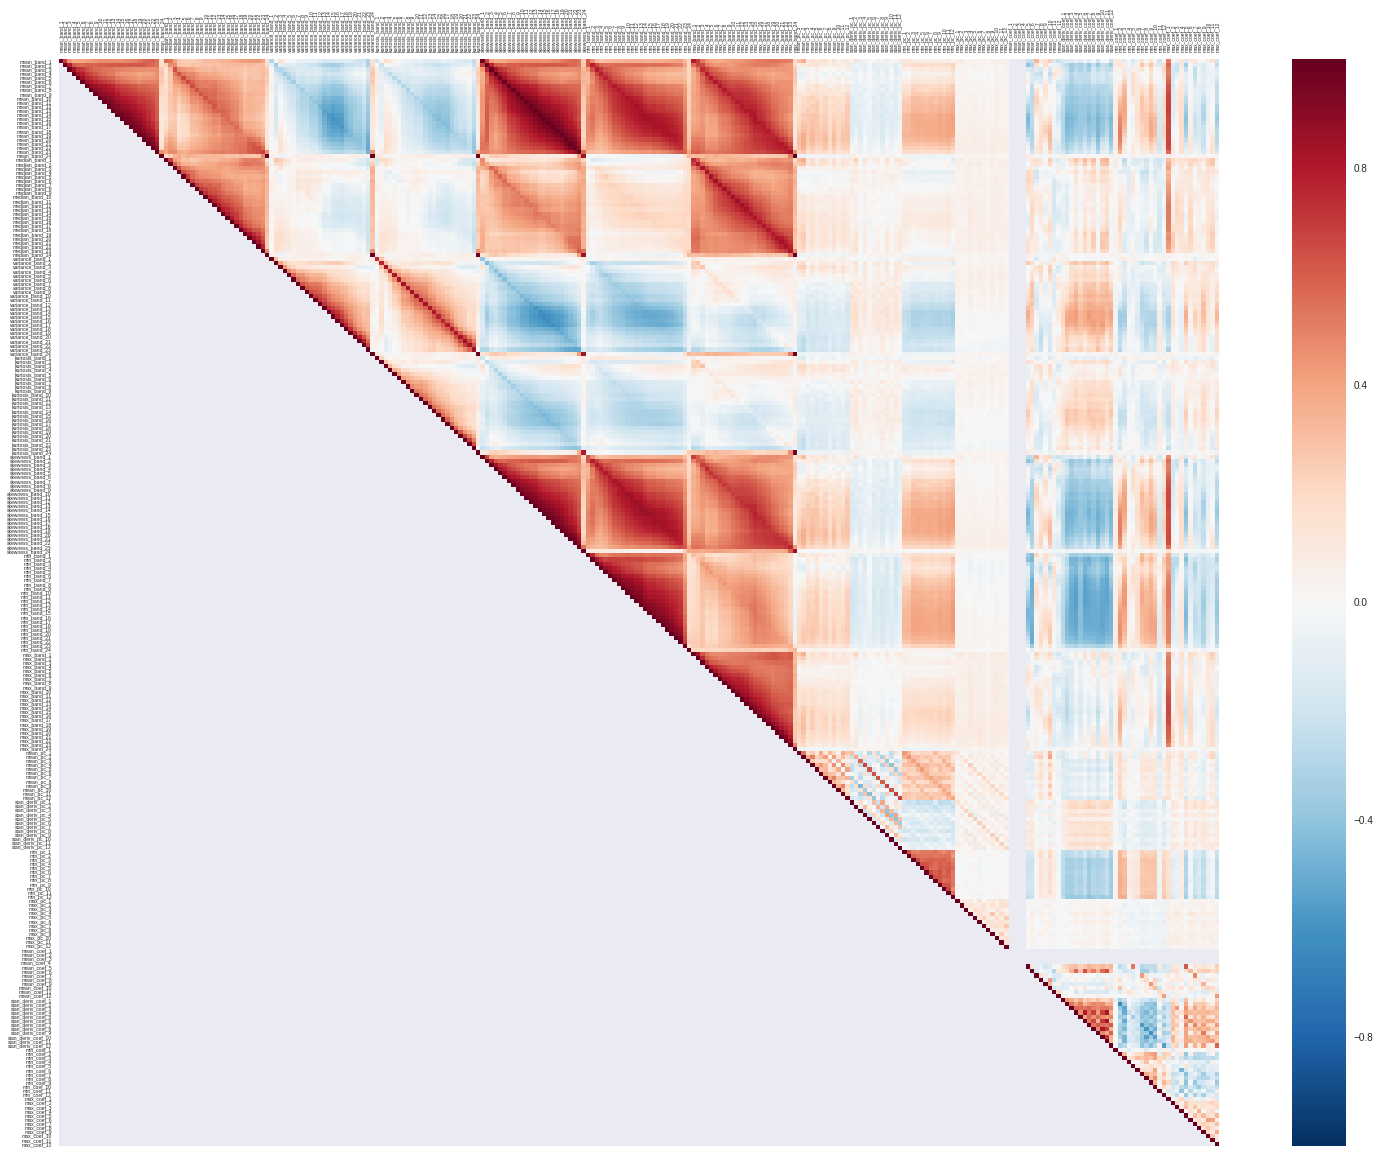

In [123]:
#Step 2: Reduce the dimensionality dropping high correlated variables (without target)

print("Step 2: Reduce the dimensionality dropping high correlated variables (without target)")
print("Let's plot the correlation matrix")
fig, ax = plt.subplots(figsize=(26,20))
corr = df_train_data_nout.corr()
# Generate a mask for the upper triangle
mask =  np.tri(corr.shape[0], k=-1)
sns.heatmap(corr, mask=mask,vmin= -1, vmax= 1 )
ax.xaxis.tick_top()
plt.yticks(rotation= 0, fontsize=5)
plt.xticks(rotation=90, fontsize=5)

This plot shows us that there are some variables which are very correlated among them. Let´s fix that

In [124]:
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold_corr)]
df_train_data_reduc = df_train_data
# Drop features 

#print('Normal without high correlated variables')
df_train_highcorr_droped = df_train_data_clean.drop(to_drop, axis=1)
#print('No outliers and no high corr')
df_train_data_nout_droped = df_train_data_nout_clean.drop(to_drop, axis=1)
#print('Delete rows in test_data')
df_test_data_drop = df_test_data_clean.drop(to_drop, axis=1)
print("Columns to drop: ")
print(to_drop)
print("Amount of elements: "+str(len(to_drop)))

      

Columns to drop: 
['mean_band_9', 'mean_band_10', 'mean_band_11', 'mean_band_12', 'mean_band_13', 'mean_band_14', 'mean_band_15', 'mean_band_16', 'mean_band_17', 'mean_band_18', 'mean_band_19', 'mean_band_20', 'mean_band_21', 'mean_band_22', 'median_band_24', 'variance_band_24', 'kurtosis_band_24', 'skewness_band_1', 'skewness_band_2', 'skewness_band_3', 'skewness_band_4', 'skewness_band_5', 'skewness_band_6', 'skewness_band_7', 'skewness_band_8', 'skewness_band_9', 'skewness_band_10', 'skewness_band_11', 'skewness_band_12', 'skewness_band_13', 'skewness_band_14', 'skewness_band_15', 'skewness_band_16', 'skewness_band_17', 'skewness_band_18', 'skewness_band_19', 'skewness_band_20', 'skewness_band_21', 'skewness_band_22', 'skewness_band_23', 'min_band_8', 'min_band_9', 'min_band_10', 'min_band_11', 'min_band_12', 'min_band_13', 'min_band_14', 'min_band_15', 'min_band_16', 'min_band_17', 'min_band_18', 'min_band_19', 'min_band_20', 'min_band_21', 'min_band_22', 'max_band_13', 'max_band_1

To check the result, two experiemnts have been performed:
 1. Check changes in the list of most correlated variables with the target
 2. Take a look of the new correlation matrix.

In [125]:
#dummies = pd.get_dummies(df_train_labels[['Column_1']])

union = pd.concat([df_train_highcorr_droped, dummies ], axis = 1)


corr = union.corr()

print('Correlations with the dummy variables')
for i in range(1,11):
    print('Correlations of: '+str(i))
    print(corr["Column_1_"+str(i)].sort_values(ascending  = False).take(range(0,10)))

Correlations with the dummy variables
Correlations of: 1
Column_1_1     1.000000
min_band_2     0.425299
min_band_7     0.380389
min_band_3     0.361746
min_band_6     0.341903
min_band_4     0.322318
min_band_5     0.316219
mean_band_2    0.311786
min_coef_3     0.308075
min_band_1     0.291587
Name: Column_1_1, dtype: float64
Correlations of: 2
Column_1_2           1.000000
stan_deriv_coef_2    0.348040
stan_deriv_coef_3    0.230584
mean_coef_11         0.226120
mean_pc_1            0.199153
max_coef_5           0.197680
variance_band_15     0.194969
variance_band_16     0.194225
stan_deriv_coef_5    0.194149
stan_deriv_coef_6    0.193347
Name: Column_1_2, dtype: float64
Correlations of: 3
Column_1_3            1.000000
stan_deriv_coef_8     0.389792
median_band_1         0.364733
stan_deriv_coef_10    0.348988
variance_band_2       0.309747
mean_coef_6           0.280035
stan_deriv_coef_11    0.263407
median_band_20        0.259195
median_band_19        0.254997
median_band_21      

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
         63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
         72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
         81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
         90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
         99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
        108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
        117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
      

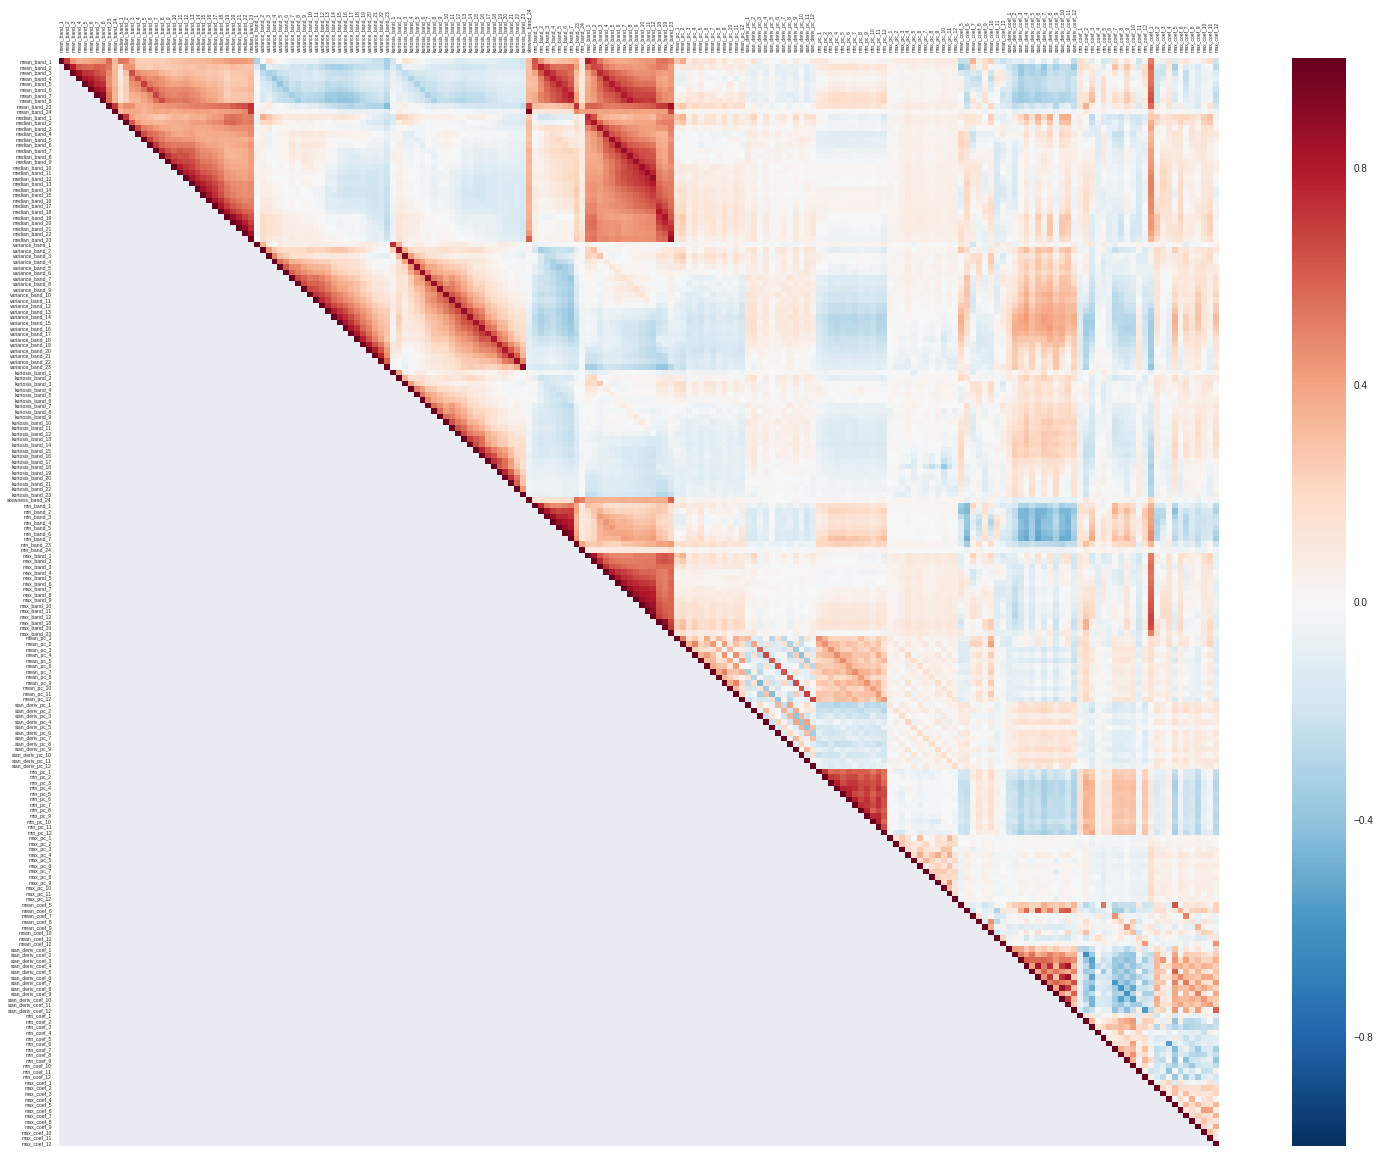

In [126]:
fig, ax = plt.subplots(figsize=(26,20))
corr = df_train_highcorr_droped.corr()
# Generate a mask for the upper triangle
mask =  np.tri(corr.shape[0], k=-1)
sns.heatmap(corr, mask=mask,vmin= -1, vmax= 1 )
ax.xaxis.tick_top()
plt.yticks(rotation= 0, fontsize=5)
plt.xticks(rotation=90, fontsize=5)

In the last 2 test, we can see that the most important variables for the category 1 (which were highly correlated among them) just one of them has been kept and that there are less red dots in the correlation matrix plot.

Therefore we can conclude that our cleaning has been done successfully 


Now, after all this preprocessin, we have 4 dataset:


1.   Normal training dataset
2.   Dataset without outliers
3.   Dataset after dropping the most correlated variables among them
4.   Combination of the second and third dataset. (without outliers and most correlated variables)

We think that it is not enough to find the best data to feed our model so we decided to use other way to reduce the dimensionality: PCA.

In the following code we take all of the dataset already mentioned, apply PCA for each one and feed the model with the normal version and the PCA one automatically. 

In [19]:
# Trials with ML algorithms

names = ["Logistic Regression","SVC Lineal","Neural Net"]


classifiers = [LogisticRegression(),SVC(class_weight='balanced',kernel='linear', C=3.0, probability=True), MLPClassifier(alpha=1)]


cv = 3

y = df_train_labels.values.reshape(len(df_train_labels))
X_test_unlabeled = df_test_data.values 


dataset = ['Initial','Without Outliers','Drop of the high correlated variables', 'Whitout Outliers and Drop']


for el in dataset:
  print("***************** Dataset used in this model: "+el+" *****************")
  
  if (el =='Initial'):
    X = df_train_data.values
    data_to_pca = df_train_data
    #X_test_unlabeled = df_test_data.values 
  if (el =='Whitout Outliers'):
    X = df_train_data_nout.values
    X_test_unlabeled = df_train_data_nout.values
    data_to_pca = df_train_data_nout
    
  if (el =='Drop of the high correlated variables'):
    X = df_train_highcorr_droped.values
    X_test_unlabeled = df_test_data_drop.values
    data_to_pca = df_train_highcorr_droped

  if (el =='Whitout Outliers and Drop'):
    X = df_train_data_nout_droped.values
    X_test_unlabeled = df_test_data_drop.values
    data_to_pca = df_train_data_nout_droped
    
  print("Generating PCA of the dataset")
  print("Looking for the the minimum number of principal components such that 98% of the variance is retained")
  sc = StandardScaler()
  sc.fit(data_to_pca)
  x = sc.transform(data_to_pca)
  x_t = sc.transform(X_test_unlabeled)
  pca = PCA(n_components=.98) #.95 scikit-learn choose the minimum number of principal components such that 95% of the variance is retained.

  principalComponents = pca.fit_transform(x)
  test_pca = pca.transform(x_t)

  

  df_pca = pd.DataFrame(data = principalComponents)
  df_test_pca = pd.DataFrame(data = test_pca)
  columnsPCA = []
  for i in range(1,len(df_pca.columns)+1):
    columnsPCA.append("PCA_"+str(i))
  
  print("PCA performed, there are "+ str(i)+" columns in PCA")
  
  df_pca.columns = columnsPCA
  df_test_pca.columns = columnsPCA

  
 
  
  
  for name, classifier in zip(names, classifiers):
    print() 
    print("----- " +name+ " Tests of the "+el+" Dataset -----")          
    clf = classifier
    
    
    classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), clf)

    
    scores = cross_val_score(classifier_pipeline, X, y, cv=cv)

    accuracy_val_score = scores.mean()

    print('Cross Validation Accuracy of {} classifier with Standardscaler features: {:.3f}'.format(name,accuracy_val_score))




    # Create a pipeline that scales the data then trains a support vector classifier
    classifier_pipeline = make_pipeline(preprocessing.MinMaxScaler(), clf)

    
    # applying the classifier pipeline to the feature and target data
    scores = cross_val_score(classifier_pipeline, X, y, cv=cv)

    accuracy_val_score = scores.mean()

    print('Cross Validation Accuracy of {} classifier with MinMaxScaler features: {:.3f}'
         .format(name,accuracy_val_score))
    
    name_best_model = 'logistic regression'
    best_model_pipeline = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
  

  
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    best_model= best_model_pipeline.fit(X_train,y_train)

    y_test_unlabeled = best_model.predict(X_test_unlabeled)

    y_semisupervised = np.concatenate((y, y_test_unlabeled))

    X_semisupervised = np.concatenate((X, X_test_unlabeled))

    best_model= best_model_pipeline.fit(X_semisupervised,y_semisupervised)
    accuracy_best_model = best_model.score(X_test,y_test)


    print('SEMI-SUPERVISED LEARNING---Cross Validation Accuracy of {} (best classifier): {:.3f}'
         .format(name_best_model,accuracy_best_model))
    
    
    print()
    
    ######################  PCA   ####################
          
    print("----- Apply "+name+" Model to PCA of "+el+" -----")
    
    scores = cross_val_score(classifier_pipeline, df_pca, y, cv=cv)

    accuracy_val_score = scores.mean()

    print('PCA---Cross Validation Accuracy of {} classifier with Standardscaler features: {:.3f}'.format(name,accuracy_val_score))

    
    scores = cross_val_score(classifier_pipeline, df_pca, y, cv=cv)

    accuracy_val_score = scores.mean()

    print('PCA---Cross Validation Accuracy of {} classifier with MinMaxScaler features: {:.3f}'
         .format(name,accuracy_val_score))
    
    X_train, X_test, y_train, y_test = train_test_split(df_pca, y)
    
    best_mode_pcal= best_model_pipeline.fit(X_train,y_train)

    y_test_unlabeled = best_model.predict(df_test_pca)

    y_semisupervised = np.concatenate((y, y_test_unlabeled))

    X_semisupervised = np.concatenate((df_pca, df_test_pca))

    best_model= best_model_pipeline.fit(X_semisupervised,y_semisupervised)
    accuracy_best_model = best_model.score(X_test,y_test)


    print('PCA---SEMI-SUPERVISED LEARNING---Cross Validation Accuracy of {} (best classifier): {:.3f}'
           .format(name_best_model,accuracy_best_model))
    print()

***************** Dataset used in this model: Initial *****************
Generating PCA of the dataset
Looking for the the minimum number of principal components such that 98% of the variance is retained
PCA performed, there are 140 columns in PCA

----- Logistic Regression Tests of the Initial Dataset -----
Cross Validation Accuracy of Logistic Regression classifier with Standardscaler features: 0.639
Cross Validation Accuracy of Logistic Regression classifier with MinMaxScaler features: 0.645
SEMI-SUPERVISED LEARNING---Cross Validation Accuracy of logistic regression (best classifier): 0.685

----- Apply Logistic Regression Model to PCA of Initial -----
PCA---Cross Validation Accuracy of Logistic Regression classifier with Standardscaler features: 0.618
PCA---Cross Validation Accuracy of Logistic Regression classifier with MinMaxScaler features: 0.618
PCA---SEMI-SUPERVISED LEARNING---Cross Validation Accuracy of logistic regression (best classifier): 0.666

----- SVC Lineal Tests of t

Unfortunately, altought all the preprocesiing performed, the accuracy of the models have not improved from the initial dataset. 

After having a deeper look to our data we found that it is not balanced, the most of our records are from the category 1 and looking for outliers does not make any sense as for example if we change them for the mean of the colums we will introduce new trends, it would be affected because the large amount of the 1 category records.

Therefore, we decided to find ways to balance our data. The aproach we  followed is to dereasse the number of category 1 records and to increasse the others.

The next code does that job.


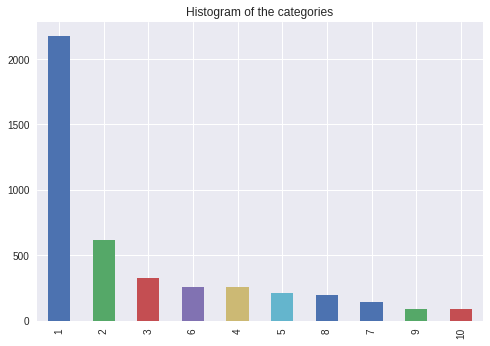

In [86]:
df_train_labels.Column_1.value_counts().plot(kind='bar',title='Histogram of the categories')

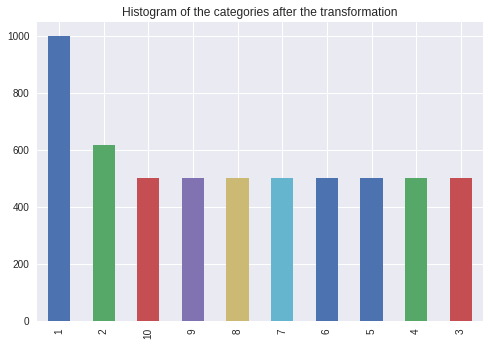

In [87]:
#Balance the data
 
union = pd.concat([df_train_data, df_train_labels ], axis = 1)
info = union.Column_1.value_counts()
result = pd.DataFrame()

for cat in range(1,11):
  
    data_to_res = union[union.Column_1 == cat]
          
    samples = info[cat]
    if(info[cat] < 500):
        samples = 500
    if(cat == 1):
        samples = 1000
    df = resample(data_to_res, replace=True, n_samples=samples)

    result = pd.concat([result,df])



result.Column_1.value_counts().plot(kind='bar',title='Histogram of the categories after the transformation')
result = result.sample(n=result.shape[0])

df_train_labels = pd.DataFrame(result["Column_1"])

df_train_labels.columns = columnsL


df_train_labels["Column_1"] = df_train_labels["Column_1"].astype('category')
df_train_data = pd.DataFrame(result[columnsD])


To test this approach we have included other 2 files:


*   test_balanced_data1: In this file we take all of our initial dataset and apply our approach previoulsy explained, the result dataset is used to feed the models and run a semi-supervised learning. We got this awesome accuracy:
>Cross Validation Accuracy of stacked_LR_XGB_SVC (best classifier) with SEMI-SUPERVISED LEARNING: 0.998

>It was a super nice piece of new but it was also a suspicious one, after thinking about we had done we realized that our model was overfited as we have the same repeated data in the dataset.

*    test_balanced_data2: this file performs the same as the previous one but  we divide the training data into two dataset so when we "rebalance" the data there are new record never seen by the model. Therefore we can know if balancing our data is usefull or not.
>Our result in our test is: 0.67048, which  does not improve our original results. Then we do not use this transfromation of the data





One thing to have in mind is that we have used a Min-Max scaler to transform our data as it performed better in our test.  

In [0]:
X = df_train_data.values
y = df_train_labels.values.reshape(len(df_train_labels))
X_test_unlabeled = df_test_data.values


#Scaling data
from sklearn.preprocessing import MinMaxScaler

X, X_val, y, y_val = train_test_split(X, y,  test_size=0.1,random_state=0)

scaler = MinMaxScaler()
scaler.fit(X)
X= scaler.transform(X)
X_test_unlabeled = scaler.transform(X_test_unlabeled)
X_val= scaler.transform(X_val)


# 3. Methods and experiments

After having prepocessed our data the best we could. By that we mean having tried the different processes explained before and have taken a look to the performance on accuracy and logloss in simple ML models.

Now our aim is to find the best model and its best  hyperparameterizaiton in order to increase an decrease as much as possible the accuracy and the log-loss respectively.



## Approach and Methods chosen

We have selected 5 different ML models that usually are doing well in kaggle competitions.With those models we did a Grid Search in order to find the 3 best models out of those 5, and also its best parameters. It turned out that those models and its hyperparameters were the following ones:



1.   clf1 = LogisticRegression(C=5, penalty ='l2')
2.   clf2 = XGBClassifier(learning_rate = 0.2, n_estimators = 512)
3.   clf3 = SVC(C=1, kernel='linear',probability=True, class_weight= 'balanced')

Once we have those 3 meters we tried two different approaches of combining them looking for increasing the accuracy.Those approaches were:


1.   Stacking
2.   Voting

Link [1]  has a very good explanation on how those methods work and its main differences.

After trying them both we realized that at least for our data Voting was getting better accuracy and we end up taking it.

After that as we had a lot of test data (unlabeled), we try to perform a semi-supervised technique called pseudo-labelling in order to try to see a slight increase in the accuracy. Semi-supervised techniques are those techniques combining supervised and unsupervised ML approaches. A better explanation on that can be found in link [2].

After make the fit of the model obtained before with the concatanation of the train data and the semi-supervised data obtained we got our final model. We observed that applying  pseudolabelling the model has a slightly improve on the accuracy .






## Evaluation Methodology

First of all in order to evaluate our methods without the need to submit the results to kaggle we took 10% of the training data provided as a validation data. This data it will be taken at the beginning before training any model and will serve us to evaluate our model since this data will not be seen by the model in the whole process. The result of the evaluation of the validation data at the end should be similar as the metrics obtained after submiting to kaggle. 


Evaluating the methods with GridSearch we used cross validation of 3 in each evaluated model.
In Voting we could use 'hard' or 'soft' voting. We chose 'soft' voting (predicts the class label based on the argmax of the sums of the predicted probabilities) because showed better accuracy and also because at the same time it gives the predict probabilities that we need for the log loss function challenge.

A point to note is that once we have our final model we will fit this model with the whole  training data provided (including the mentioned validation data) in order to take the whole amount of data disponible.

## Code

### Grid Search of different Models

In [0]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=6, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [0]:
models1 = {
    'XGBClassifier': XGBClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'SVC': SVC(probability=True)
}

params1 = {
    'XGBClassifier': { 'n_estimators': [512], 'learning_rate': [0.2,0.5,0.8] },
    'RandomForestClassifier': { 'n_estimators': [512] },
    'AdaBoostClassifier':  { 'n_estimators': [512] },
    'GradientBoostingClassifier': { 'n_estimators': [256,512], 'learning_rate': [0.2,0.8, 1.0] },
    'LogisticRegression': {'penalty': ['l2'], 'C' : [0.15,1,2,5]},
    'SVC': {'kernel': ['linear'], 'C': [1, 5, 8]}
}



helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X, y, scoring='accuracy', n_jobs=8)

In [0]:
helper1.score_summary(sort_by='max_score')

The two cells above take lot of time to run therefore we include a image to show the result.


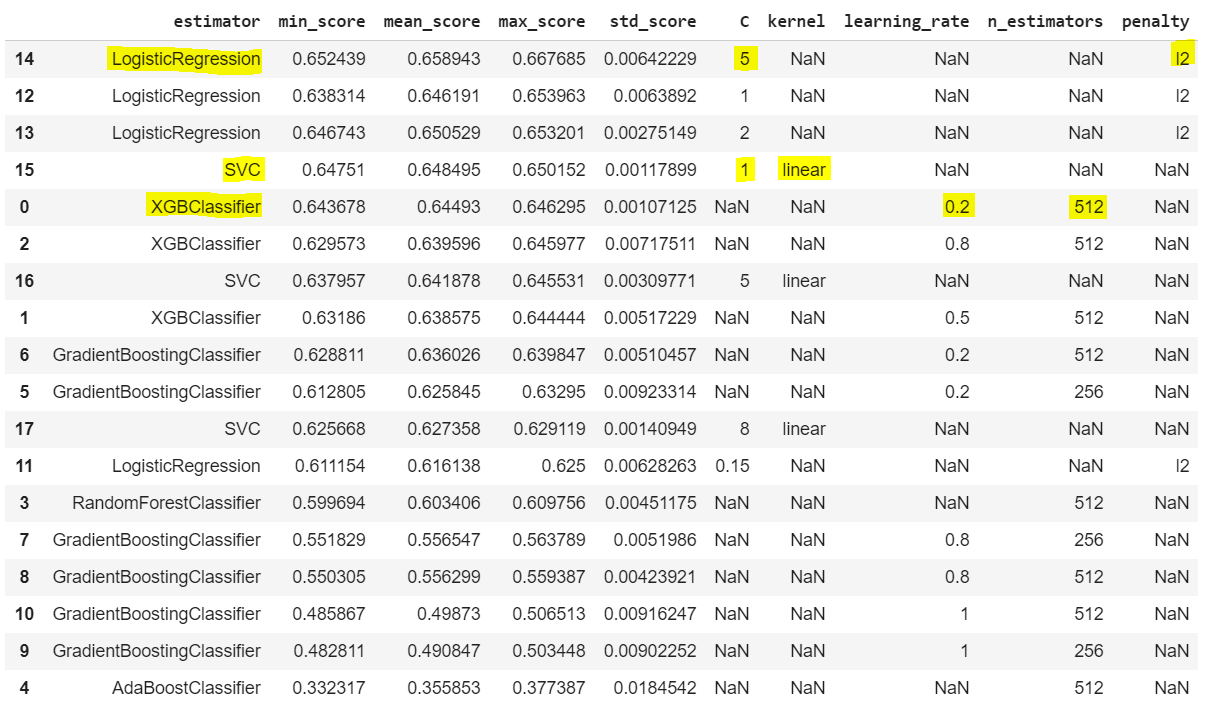

In [141]:
from IPython.display import Image
Image('table.PNG')

### Stacking and Voting

Taking the best 3 models from above.

In [128]:



clf1 = LogisticRegression(C=5, penalty ='l2')
clf2 = XGBClassifier(learning_rate = 0.2, n_estimators = 512)
clf3 = SVC(C=1, kernel='linear',probability=True, class_weight= 'balanced')



from sklearn.ensemble import VotingClassifier
sclf = VotingClassifier(estimators=[
    ('lr', clf1), ('xgb', clf2), ('svc', clf3)],
                         voting='soft')

print('3-fold cross validation:\n')

for clf, label in zip([ sclf], 
                      ['StackingClassifier']):

    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.66 (+/- 0.01) [StackingClassifier]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
name_best_model = 'stacked_LR_XGB_SVC'
best_model = sclf

best_model= best_model.fit(X,y)

### Validation (Give how good is our model with unseen data)

In [130]:

print('accuracy: ', sclf.score(X_val,y_val))

y_pred_val = best_model.predict_proba(X_val)
print('logloss: ', log_loss(y_val, y_pred_val))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy:  0.6704805491990846
logloss:  1.0708137390349313


**THIS RESULT IS THE ONE WE WILL FOCUS SINCE IT IS OBTAINED WITH THE VALIDATION DATA WHICH HAS NOT BEEN SEEN BY THE MODEL.**

### Taking the full X and y now to train the model to fit the semisupervised and also the final model.

In [0]:
X = df_train_data.values
y = df_train_labels.values.reshape(len(df_train_labels))
X_test_unlabeled = df_test_data.values


scaler.fit(X)
X= scaler.transform(X)
X_test_unlabeled = scaler.transform(X_test_unlabeled)

### Semi-supervised learning (Pseudo Labeling)


In [132]:
y_test_unlabeled = best_model.predict(X_test_unlabeled)
y_semisupervised = np.concatenate((y, y_test_unlabeled))
X_semisupervised = np.concatenate((X, X_test_unlabeled))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [133]:
best_model_ss= best_model.fit(X_semisupervised,y_semisupervised)
accuracy_best_model = best_model_ss.score(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [134]:
print('Cross Validation Accuracy of {} (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS ACCURACY IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): \n{:.3f}'
       .format(name_best_model,accuracy_best_model))


Cross Validation Accuracy of stacked_LR_XGB_SVC (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS ACCURACY IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): 
0.835


# 4. Results

### Results on the training  data on the final model that we will use:

In [135]:

print('accuracy: ', sclf.score(X,y))

y_pred = sclf.predict_proba(X)
print('logloss: ', log_loss(y, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy:  0.8345175338070135
logloss:  0.37775505490928785


### Results on the training data test after including  the final model that we will use:

In [138]:

y_pred = best_model_ss.predict_proba(X)
logloss_best_model_ss = log_loss(y,y_pred)


print('Cross Validation Accuracy of {} (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS ACCURACY IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): \n{:.3f}'
       .format(name_best_model,accuracy_best_model))

print('Cross Validation Logloss of {} (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS LOGLOSS IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): \n{:.3f}'
       .format(name_best_model,logloss_best_model_ss))

Cross Validation Accuracy of stacked_LR_XGB_SVC (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS ACCURACY IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): 
0.835
Cross Validation Logloss of stacked_LR_XGB_SVC (best classifier) with SEMI-SUPERVISED LEARNING (TAKING INTO ACCOUNT THAT THIS LOGLOSS IS ON TRAINING SINCE THIS MODEL HAVE SEEN ALL THE DATA IN X): 
0.378


### On Kaggle we obtained:




*   Accuracy:  0.67345   (7 th place in public Leaderboard)
    





*   Log Loss: 0.19062



### Confusion Matrix

In [139]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y, best_model.predict(X))

pd.crosstab(y, best_model.predict(X), rownames=['True'], colnames=['Predicted'], margins=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,1,2,3,4,5,6,7,8,9,10,All
True,,,,,,,,,,,
1,2123,38,8,2,0,7,0,0,0,0,2178
2,107,498,8,2,0,2,0,0,1,0,618
3,27,4,294,0,0,0,0,0,1,0,326
4,45,5,1,201,0,1,0,0,0,0,253
5,106,4,3,2,99,0,0,0,0,0,214
6,66,3,8,2,1,180,0,0,0,0,260
7,78,7,2,2,0,0,51,0,1,0,141
8,112,1,1,0,0,0,0,81,0,0,195
9,7,1,2,0,0,0,0,0,82,0,92


###Preparing files to submit

In [140]:
test_data_predictions = best_model_ss.predict(X_test_unlabeled)


#Create a  DataFrame with ids and our prediction 
submission = pd.DataFrame({'Sample_id':df_test_data.index.values+1,'Sample_label':test_data_predictions})

#Visualize the first 5 rows
print(submission.head(30))


#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Accuracy_v10_MinMax_nobalanced.csv'

submission.to_csv(filename,index=False)

test_data_predictions = best_model_ss.predict_proba(X_test_unlabeled)


#Create a  DataFrame with ids and our prediction 
submission2 = pd.DataFrame({'Sample_id':df_test_data.index.values+1,'Class_1':test_data_predictions[:,0],'Class_2':test_data_predictions[:,1],
                          'Class_3':test_data_predictions[:,2],'Class_4':test_data_predictions[:,3],
                          'Class_5':test_data_predictions[:,4],'Class_6':test_data_predictions[:,5],
                          'Class_7':test_data_predictions[:,6],'Class_8':test_data_predictions[:,7],
                          'Class_9':test_data_predictions[:,8],'Class_10':test_data_predictions[:,9]},
                           columns=['Sample_id','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9','Class_10'])


#Visualize the first 5 rows
print(submission2.head())


#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'LogLoss_v10_MinMax_nobalanced.csv'

submission2.to_csv(filename,index=False)

print('Saved file: ' + filename)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    Sample_id  Sample_label
0           1             3
1           2             3
2           3             1
3           4             1
4           5             1
5           6             8
6           7             1
7           8             1
8           9             1
9          10             2
10         11             1
11         12             5
12         13             1
13         14             1
14         15             1
15         16             1
16         17             3
17         18             1
18         19             3
19         20             2
20         21             2
21         22             1
22         23             1
23         24             1
24         25             1
25         26             4
26         27             3
27         28             1
28         29             1
29         30             1
   Sample_id   Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
0          1  0.157782  0.030011  0.712715  0.008838  0.

# 5. Discussion/Conclusions

## Discuss the relevance of the performance measures (accuracy and LogLoss) for imbalanced multiclass datasets.

Logarithmic Loss, or simply Log Loss, is a classification loss function often used as an evaluation metric in Kaggle competitions.  Log Loss quantifies the accuracy of a classifier by ** penalising false classifications**.
Minimising the Log Loss is basically equivalent to maximising the accuracy of the classifier, but there is a subtle twist.

![](https://datawookie.netlify.com/img/2015/12/log-loss-curve.png)

Let’s take a closer look at this relationship. The plot below shows the Log Loss contribution from a single positive instance where the predicted probability ranges from 0 (the completely wrong prediction) to 1 (the correct prediction). It’s apparent from the gentle downward slope towards the right that the Log Loss gradually declines as the predicted probability improves. Moving in the opposite direction though, the Log Loss ramps up very rapidly as the predicted probability approaches 0. That’s the twist I mentioned earlier.

Log Loss heavily penalises classifiers that are confident about an incorrect classification. For example, if for a particular observation, the classifier assigns a very small probability to the correct class then the corresponding contribution to the Log Loss will be very large indeed. Naturally this is going to have a significant impact on the overall Log Loss for the classifier. The bottom line is that it’s better to be somewhat wrong than emphatically wrong. Of course it’s always better to be completely right, but that is seldom achievable in practice! 


## Suggestions for future research/improvement.



1.   Examine the problematic observations relative to the full data set. With problematic observations we mean those predicted wrong and with a higer probability. Maybe if they are some kind of outliers and it can be removed and re-train the classifier again.
2.   We could have tried some feature engineering.  Since our time was limited and also we do not know a lot about the music industry it was quite a challenge to do so and we focused more in other aspects of the project.
3.   Try other approaches to deal with unbalanced data. We tried Upsampling and Downsampling but that did not provide better models. Maybe other approaches as the ones explained in [3] could have been tried. For example focusing in increasing the AUC ROC of the model, specially in imbalanced data, could be better than focusing on accuracy or logloss.
4.   Eventhough we look the correlation between features and labels and we also performed PCA, maybe a deeper research on calculating correlation between numeric and categoric variables as well as other type of feature importance techniques could be done in the future.



## - Did the study answer your questions?

That project served us to realized that accuracy alone is not the only metric to take into account in order to find a good model. Moreover, if the problem carries imbalanced data, that fact is even more remarkable.

Also, the project showed us that there is almost never a single better approach in Machine Learning. Often, several approaches have to be tried and keep the one that gives us the better performance for each specific dataset.

# 6. References

[1] https://www.linkedin.com/pulse/comparing-voting-stacking-optimal-pipelines-python-subrata-chatterjee/

[2] https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b

[3] https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/

[4] https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba 

[5] https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

[6] https://elitedatascience.com/imbalanced-classes



# Apendix

We also include the test of the balanced data already explained and the image of the Grid result.



*   test_balance1.ipynb
*   test_balance2.ipynb
*   table.PNG

